In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

dataset = pd.read_csv(filepath_or_buffer='pretreatmented_data.csv', header=None)
FEATURES_INDEX = np.arange(50)
LABELS_INDEX = 50
BATCH_SIZE = 50
LOSS_THRESHOLD = 1e-7
dataset.head()

spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True)
spam_dataset.reset_index(drop=True, inplace=True)
nonspam_dataset.tail()

rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam)
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

In [2]:
FEATURES_INDEX = [0, 1]
LABELS_INDEX = 2
LOSS_THRESHOLD = 1e-6

In [3]:
learn_dataset = pd.read_csv('learn_data.csv', index_col=0)
valid_dataset = pd.read_csv('valid_data.csv', index_col=0)
test_dataset = pd.read_csv('test_data.csv', index_col=0)
learn_dataset.head()

,0,1,2
0,0.980200,-0.735111,-0.573921
1,-1.758554,0.527610,2.068426
2,0.066156,0.404232,-0.447753
3,0.919834,-0.836112,-0.615778
4,-0.676431,-0.458955,0.800171


In [4]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [5]:
learn_dataloader = DataLoader(learn_dataset, batch_size=len(learn_dataset), shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.tanh(self.lin3(x))
        x = self.lin4(x)
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
#Инициализация весов
STD = [(2/(2+10+1))**(1/2), (2/(10+10+1))**(1/2), (2/(10+5+1))**(1/2), (2/(5+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
tensor([-0.0369, -0.3642, -0.8628, -0.0360, -0.2783, -0.6433,  0.5229,
        -0.3453,  0.1067, -1.1462])


In [8]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([-0.0369, -0.3642, -0.8628, -0.0360, -0.2783, -0.6433,  0.5229,
        -0.3453,  0.1067, -1.1462])

In [9]:
criterion = nn.MSELoss(size_average=True)
lr = 0.001

In [12]:
%%time
learn_loss_by_lr = []
valid_loss_by_lr = []
test_loss_by_lr = []
epoch_loss_by_lr = []
mu_list = [0, 0.3, 0.6, 0.9]

for mu in mu_list:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=mu)
    
    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)
    
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []
    
    for epoch in range(5*10**3):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))
        
        #критерий останова
        if (epoch > 10) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lr: ', lr, ' breaked on epoch: ', epoch, '\n')
            break
            
        if epoch % 100 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))
                
            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))
                
    learn_loss_by_lr.append(learn_epoch_loss)
    valid_loss_by_lr.append(valid_epoch_loss)
    test_loss_by_lr.append(test_epoch_loss)
    epoch_loss_by_lr.append(epoch_list)

-9.5367431640625e-07
lr:  0.001  breaked on epoch:  3732 

CPU times: user 28min 54s, sys: 16.6 s, total: 29min 10s
Wall time: 9min 46s


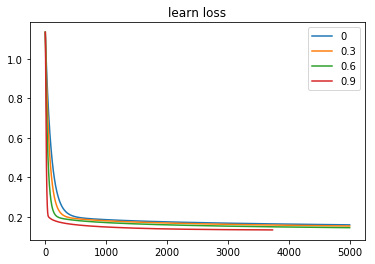

In [14]:
#learn
for num, i in enumerate(mu_list):
    plt.plot(learn_loss_by_lr[num], label=str(i))
plt.title('learn loss')
plt.legend()
plt.savefig('nikgdmoment/learn_loss.png', bbox_inches='tight')

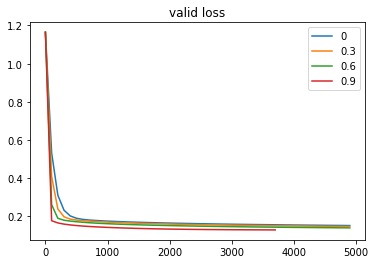

In [15]:
#valid
for num, i in enumerate(mu_list):
    plt.plot(epoch_loss_by_lr[num], valid_loss_by_lr[num], label=str(i))
plt.title('valid loss')
plt.legend()
plt.savefig('nikgdmoment/valid_loss.png', bbox_inches='tight')

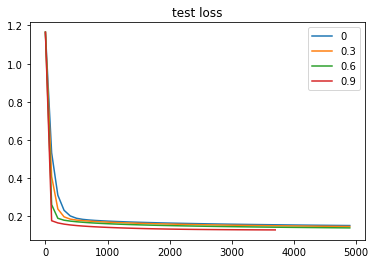

In [16]:
#test
for num, i in enumerate(mu_list):
    plt.plot(epoch_loss_by_lr[num], test_loss_by_lr[num], label=str(i))
plt.title('test loss')
plt.legend()
plt.savefig('nikgdmoment/test_loss.png', bbox_inches='tight')

In [17]:
#learn
for num, i in enumerate(mu_list):
    print(learn_loss_by_lr[num][-1])

0.1593666672706604
0.1535906046628952
0.14507754147052765
0.13371022045612335


In [18]:
#test
for num, i in enumerate(mu_list):
    print(test_loss_by_lr[num][-1])

0.1525457352399826
0.1476527601480484
0.14028312265872955
0.12966100871562958


In [20]:
%%time
learn_loss_by_lr = []
valid_loss_by_lr = []
test_loss_by_lr = []
epoch_loss_by_lr = []
mu_list = [1e-30, 0.3, 0.6, 0.9]

for mu in mu_list:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=mu, nesterov=True)
    
    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)
    
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []
    
    for epoch in range(5*10**4):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))
        
        #критерий останова
        if (epoch > 10) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lr: ', lr, ' breaked on epoch: ', epoch, '\n')
            break
            
        if epoch % 1000 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))
                
            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))
                
    learn_loss_by_lr.append(learn_epoch_loss)
    valid_loss_by_lr.append(valid_epoch_loss)
    test_loss_by_lr.append(test_epoch_loss)
    epoch_loss_by_lr.append(epoch_list)

-9.98377799987793e-07
lr:  0.001  breaked on epoch:  11026 

-9.834766387939453e-07
lr:  0.001  breaked on epoch:  9887 

-9.238719940185547e-07
lr:  0.001  breaked on epoch:  8094 

-9.98377799987793e-07
lr:  0.001  breaked on epoch:  3714 

CPU times: user 51min 41s, sys: 40.2 s, total: 52min 21s
Wall time: 18min 5s


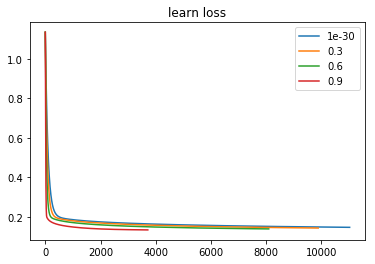

In [23]:
#learn
for num, i in enumerate(mu_list):
    plt.plot(learn_loss_by_lr[num], label=str(i))
plt.title('learn loss')
plt.legend()
plt.savefig('nikgdmoment/learn_loss.png', bbox_inches='tight')

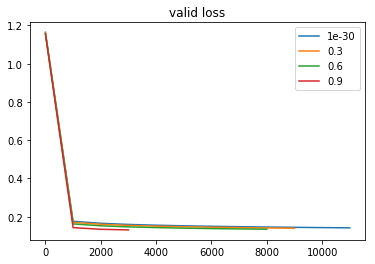

In [24]:
#valid
for num, i in enumerate(mu_list):
    plt.plot(epoch_loss_by_lr[num], valid_loss_by_lr[num], label=str(i))
plt.title('valid loss')
plt.legend()
plt.savefig('nikgdmoment/valid_loss.png', bbox_inches='tight')

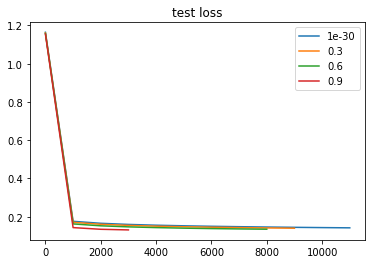

In [25]:
#test
for num, i in enumerate(mu_list):
    plt.plot(epoch_loss_by_lr[num], test_loss_by_lr[num], label=str(i))
plt.title('test loss')
plt.legend()
plt.savefig('nikgdmoment/test_loss.png', bbox_inches='tight')

In [26]:
#learn
for num, i in enumerate(mu_list):
    print(learn_loss_by_lr[num][-1])

0.14690977334976196
0.14337486028671265
0.13893277943134308
0.13380968570709229


In [27]:
#learn
for num, i in enumerate(mu_list):
    print(test_loss_by_lr[num][-1])

0.14168620109558105
0.13968536257743835
0.13454663753509521
0.13079988956451416
